In [207]:
import numpy as np
import matplotlib.pyplot as plt
import utilities
utilities.init(use_latex=False)

# Boltzmann's constant (scale units so that K_B = 1)
K_B = 1

# Kinetic Monte Carlo

## The solid-on-solid model for crystals








In [319]:
def plot_film(ax, state, ylim):
    D = len(state)
    ax.fill_between(np.arange(D),
                    state, 
                    ylim[0], step='post', alpha=0.8)
    #ax.plot(state, color='w', alpha=0.8, ds='steps-post', linewidth=1)
    ax.set_ylim(ylim)
    ax.set_xlim([0,D-1])
    ax.set_xticks(np.arange(D), labels =[None]*D)
    ax.set_yticks(np.arange(ylim[0], ylim[1]), labels=[None]*(ylim[1]-ylim[0]))
    ax.grid(color='w', linewidth=0.4)

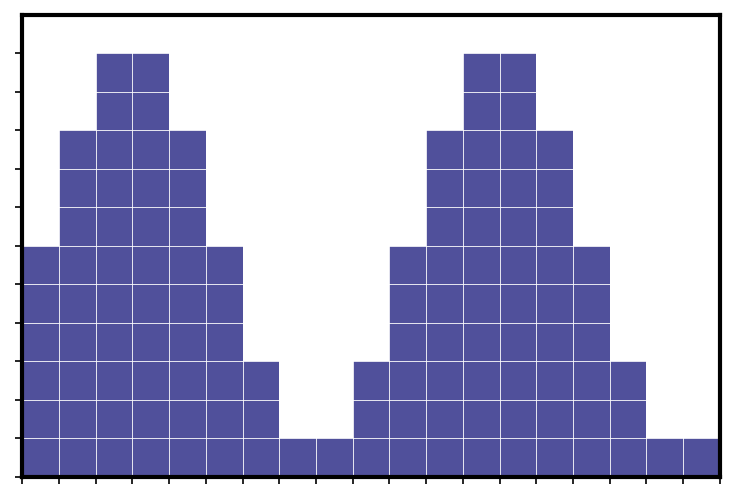

In [320]:
D = 20
x = np.arange(D)
state = np.round(0.25*D*np.sin((4*np.pi/D) * x))

plt.figure(figsize=(6, 4))
plot_film(plt.gca(), state, [-6, 6])

In [205]:
def count_bonds(state):
    """
    Counts the number of bonds connected to the 
    top atom, at each lattice site.
    """
    
    return (1 + 
            (state <= np.roll(state,  1)) + 
            (state <= np.roll(state, -1)))

In [206]:
num_bonds = count_bonds(state)

print("Top atom at position %d has %d bonds."%(2, num_bonds[2]))
print("Top atom at position %d has %d bonds."%(7, num_bonds[7]))

Top atom at position 2 has 2 bonds.
Top atom at position 7 has 3 bonds.


In [238]:
# Hopping frequency prefactor (scale units so that prefactor = 1)
PREFACTOR = 1

def calculate_hopping_rates(state, bond_energy, temp):  
    num_bonds = count_bonds(state)
    activation_energies = num_bonds*bond_energy
    rates = PREFACTOR * np.exp(-activation_energies/(K_B*temp))
    return rates

In [239]:
BOND_ENERGY = 1
TEMP = 10

rates = calculate_hopping_rates(state, BOND_ENERGY, TEMP)
print("Hopping rate for top atom at position %d = %f."%(2, rates[2]))
print("Hopping rate for top atom at position %d = %f."%(7, rates[7]))
print("Ratio =  %f."%(rates[2] / rates[7]))


Hopping rate for top atom at position 2 = 0.818731.
Hopping rate for top atom at position 7 = 0.740818.
Ratio =  1.105171.


What is the effect of temperature and bond energy?

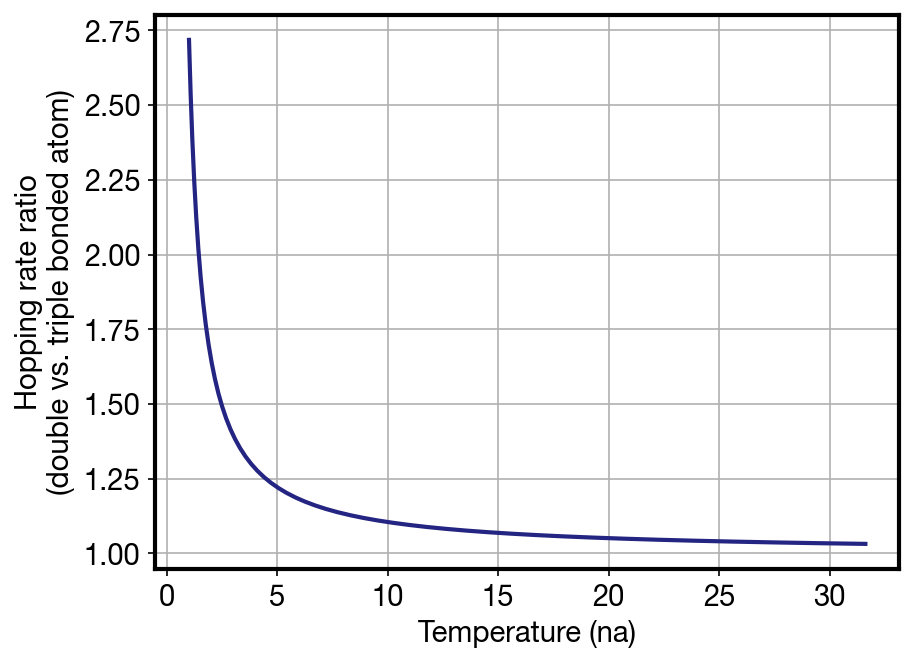

In [240]:
temps = np.logspace(0, 1.5)
ratios = np.zeros(len(temps))

for i, temp in enumerate(temps):
    rates = calculate_hopping_rates(state, BOND_ENERGY, temp)
    ratios[i] = rates[2] / rates[7]
    
plt.plot(temps, ratios)
plt.grid()
plt.xlabel('Temperature (na)')
plt.ylabel('Hopping rate ratio\n(double vs. triple bonded atom)');

In [284]:
def run_kmc(rng, initial_state, bond_energy, temp, num_steps):
    length = len(initial_state)
    
    state_hist = np.zeros((num_steps, length))
    state_hist[0] = initial_state
    time_hist = np.zeros(num_steps)
    
    for n in range(0, num_steps-1):

        # Copy old state (we'll only change two entries for an atom hop)
        state_hist[n+1] = state_hist[n]
        
        # Calculate rates for hopping top atoms
        rates = calculate_hopping_rates(state_hist[n+1], bond_energy, temp)
        
        # normalize rates to get probabilities
        Z = np.sum(rates)
        probs = rates / Z
        
        # sample an atom to hop
        i = rng.choice(length, p=probs)
        state_hist[n+1, i] -= 1
        
        # Pick hop left or hop right (uniformly at random)
        if rng.uniform() < 0.5: 
            state_hist[n+1, (i-1+length)%length] += 1 # hop left   
        else:
            state_hist[n+1, (i+1)%length] += 1 # hop right 
            
        # increment clock by expected minimum time = 1 / sum of rates
        time_hist[n+1] = time_hist[n] + 1/Z
        
    return state_hist, time_hist   
    

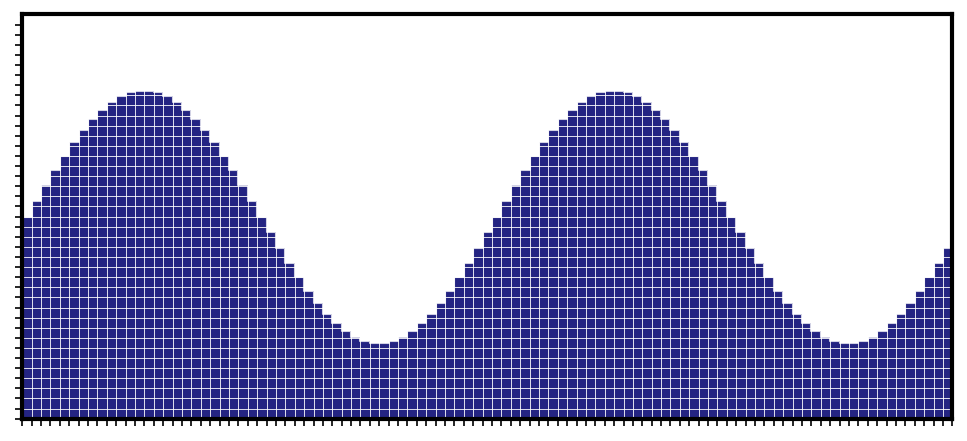

In [300]:
D = 100
x = np.arange(D)
initial_state = 0.125*D*np.sin((4*np.pi/D) * x)

plt.figure(figsize=(8, 3.5))
plot_film(plt.gca(), initial_state, [-20, 20])

In [340]:
RNG = np.random.default_rng(seed=12345)
BOND_ENERGY = 1
TEMP = 1
NUM_STEPS = int(1e6)

state_hist, time_hist = run_kmc(RNG, initial_state, BOND_ENERGY, TEMP, NUM_STEPS)

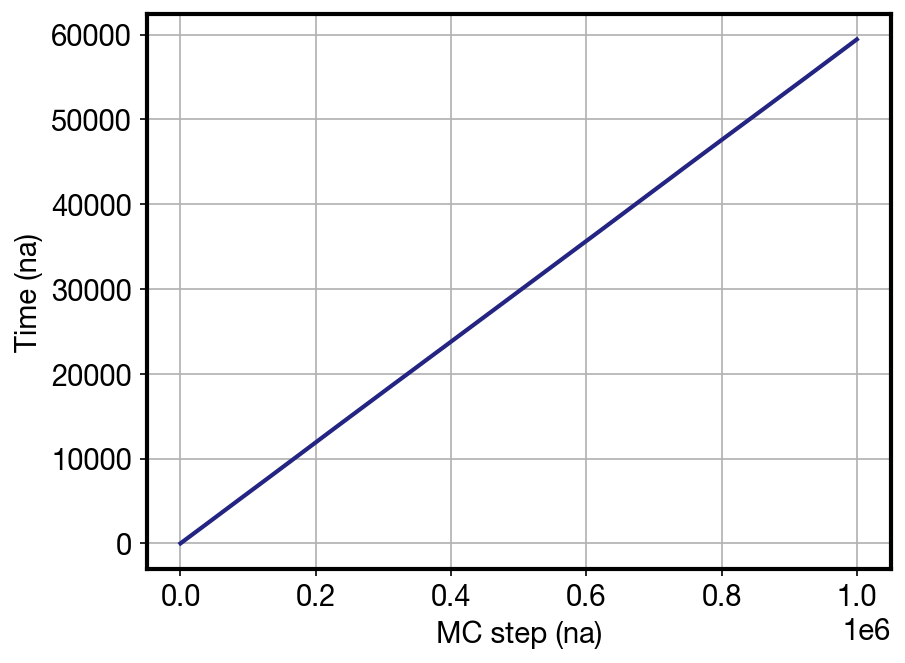

In [341]:
plt.plot(time_hist)
plt.xlabel('MC step (na)')
plt.ylabel('Time (na)')
plt.grid();

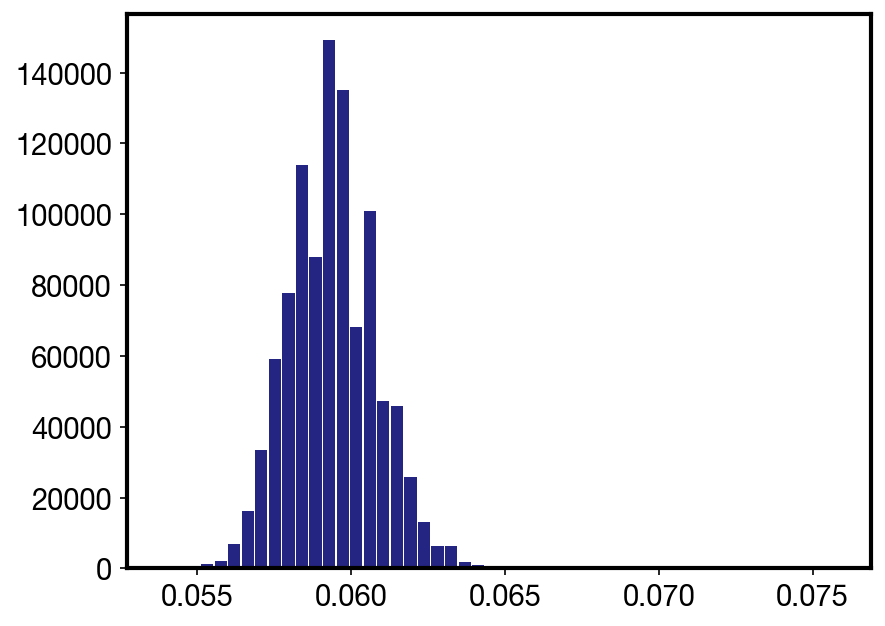

In [350]:
time_in_state = time_hist[1:] - time_hist[:-1]
plt.hist(time_in_state, bins=50, rwidth=0.9);

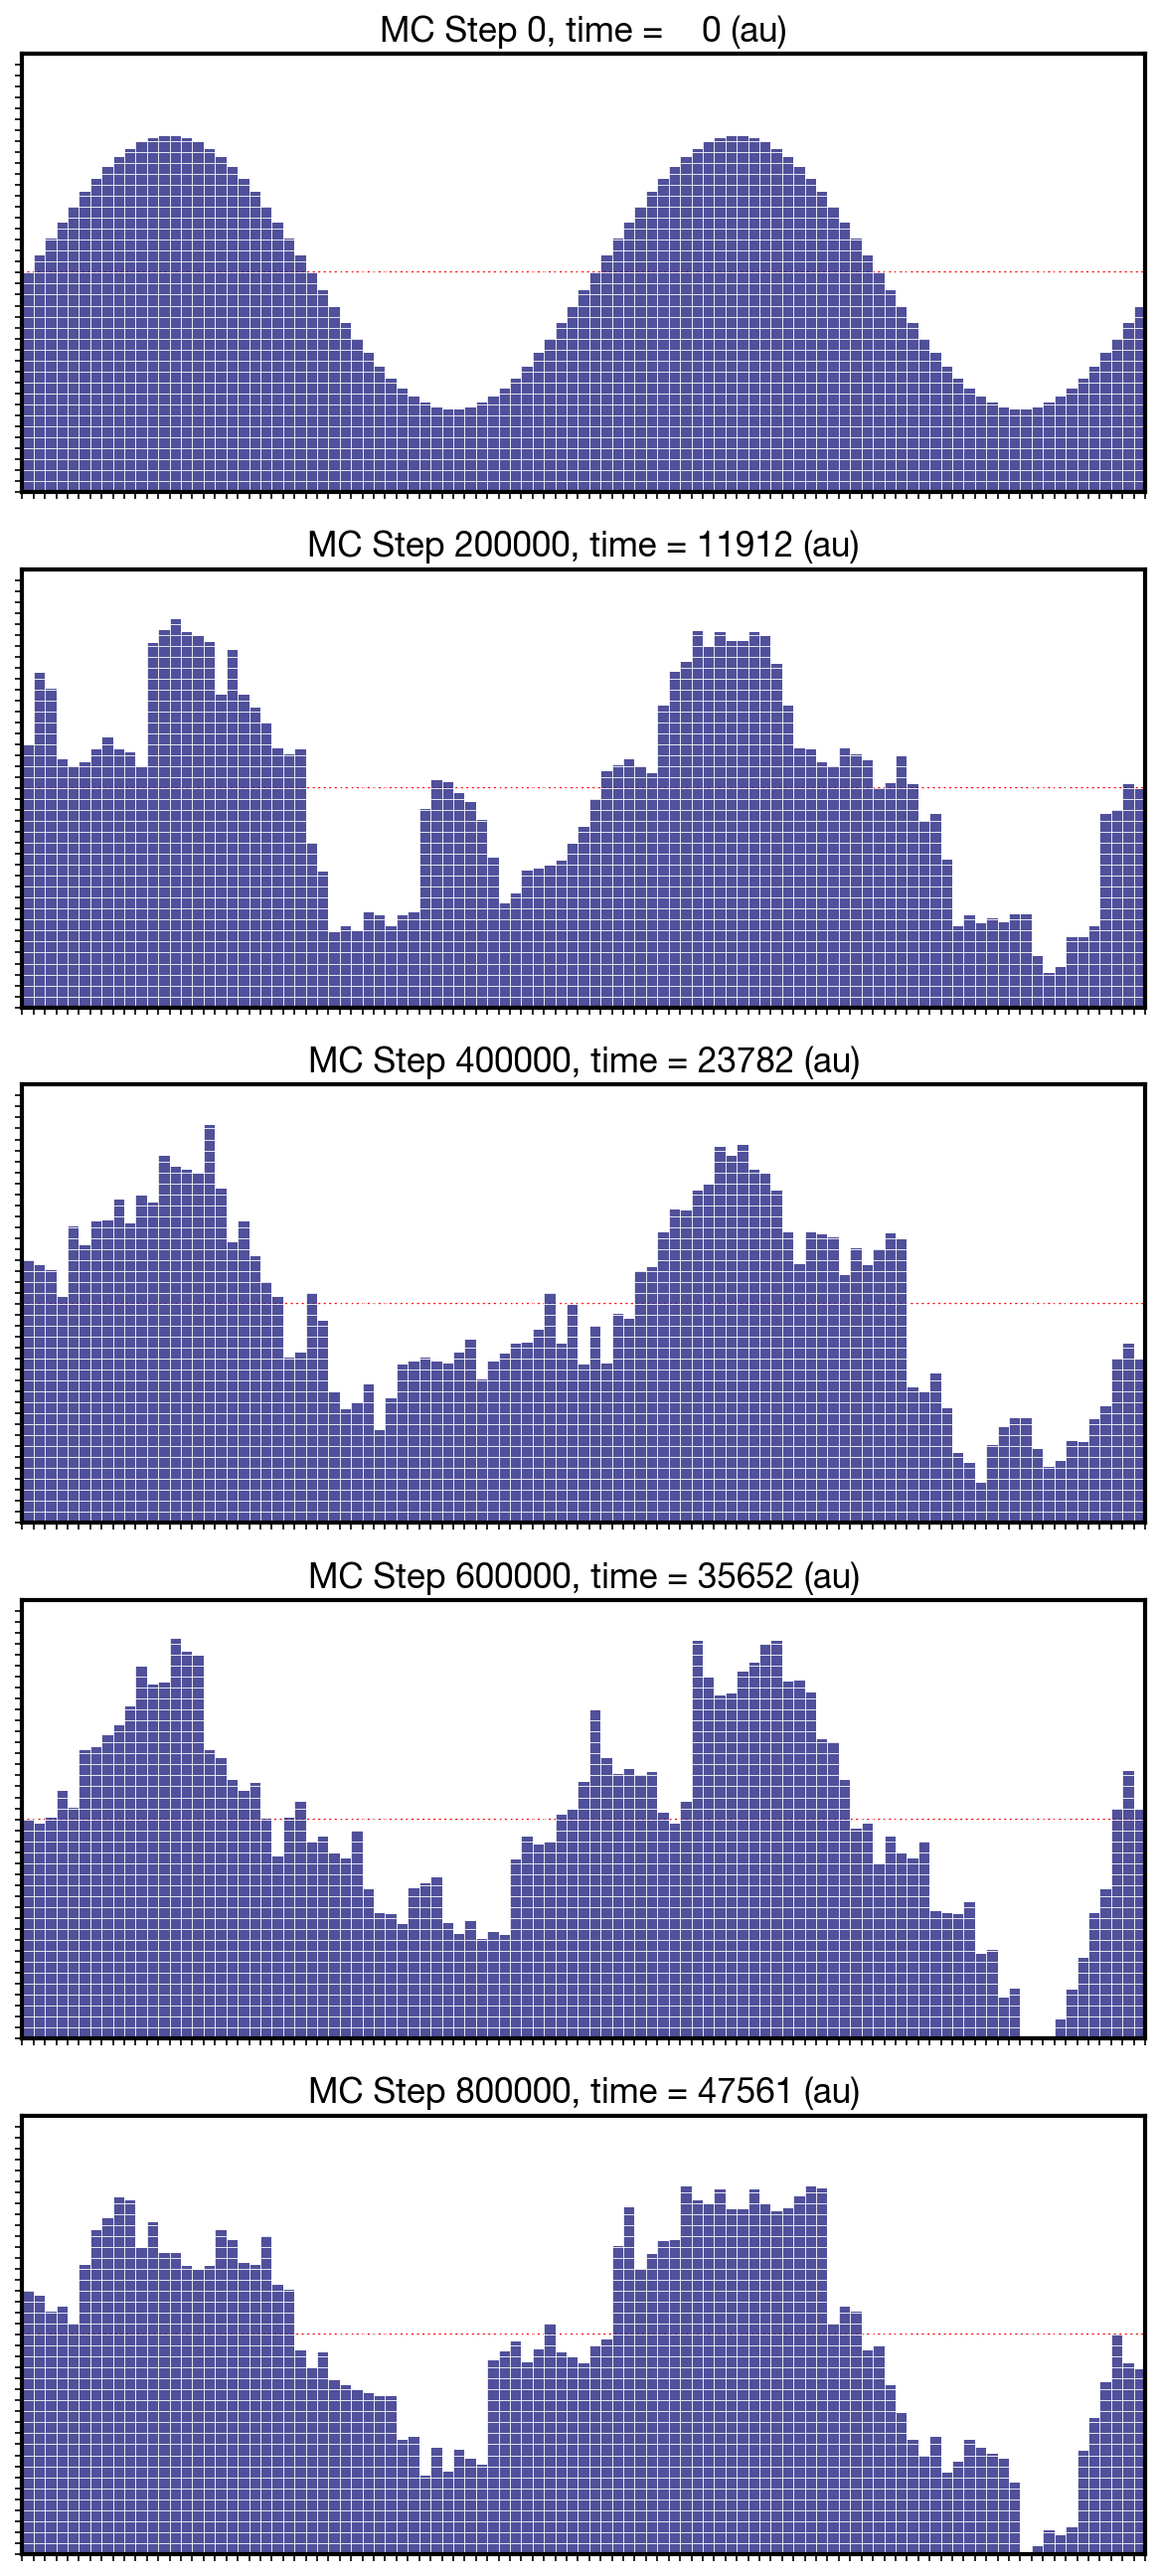

In [342]:
NUM_SUBPLOTS = 5

plt.figure(figsize=(8, 3.5*NUM_SUBPLOTS))

for i, n in enumerate(range(0, NUM_STEPS, NUM_STEPS//NUM_SUBPLOTS)):
    plt.subplot(NUM_SUBPLOTS, 1, i+1)
    plot_film(plt.gca(), state_hist[n], [-20, 20])
    plt.axhline(y=0, color='r', linewidth=1, linestyle = ":", zorder=-1)
    plt.title('MC Step %d, time = %4.0f (au)'%(n, time_hist[n]))
    
plt.tight_layout()

This is just one Markov chain. Where does this fit into workflow?

## Further discussion
* What about systems with more types, or motifs, of events?
    * Will time-in-state distribution look different?
* Quantities of interest?
    * Surface roughness?
    * Surface feature spacing?
    * Total energy (versus reference state)?
    
    